# Ensembling: Blending and Stacking

## Introduction

In this notebook, we implement an ensembling technique called **stacking**. Ensemble machine learning methods combine multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms. That is, instead of getting predictions from a single best model, we combine predictions of multiple models.

Many of the popular modern machine learning algorithms are actually ensemble methods. Bagging and random forests average predictions from many decision trees to reduce prediction variance and become robust to outliers and noise; ultimately leading to greater predictive accuracy. Boosted decision trees are another ensemble approach that slowly learns unique patterns in the data by sequentially combining individual, shallow trees. Observe that these two approaches combines similar models that are trained differently. Stacking, on the other hand, ensembles a diverse group of **strong learners**. That is, we combine any set of machine learning models, regardless of the architecture and training algorithm, as long as they are trained on the same task. 

Implementing stacking successfully mainly requires good cross-validation strategy between levels of prediction. In particular, we will demonstrate that maintaining the same cross-validation folds between levels, minimizes the risk of overfitting.

```{figure} ../img/stacking.png
---
width: 45em
name: stacking
---
Stacking with $k$-fold cross-validation. Each new data point ${\mathbf{x}^\prime}^{[i]}$ has $T$ features corresponding to predictions of each base model for $\mathbf{x}^{[i]}$. Note line 10 should be: "**for** $i \leftarrow 1$ to $n = |\mathcal{D}_k|$ **do**" where predictions are made on $\mathbf{x}^{[i]} \in \mathcal{D}_k.$ {cite}`stat451` lec. 7.
```

```{figure} ../img/hypothesis_space.png
---
width: 45em
name: hypothesis
---
An ensemble can have a larger hypothesis space than each single model. {cite}`stat451` lec. 1.
```

In [1]:
import pandas as pd
import numpy as np
import time
import joblib
import random
from joblib import Parallel, delayed
from scipy.optimize import minimize
from xgboost import XGBClassifier

from sklearn import model_selection, linear_model, metrics, decomposition, ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone

from tqdm.notebook import tqdm as tqdm
from functools import partial, reduce
from typing import List
import warnings
warnings.simplefilter(action='ignore')

# config
random.seed(42)
np.random.seed(42)
NUM_FOLDS = 5

## Dataset

The dataset consists of 50,000 IMDB movie reviews, specially selected for sentiment analysis. The sentiment of reviews is binary, with rating < 5 results in a sentiment score of 0, and rating ≥ 7 resulting in a sentiment score of 1. No individual movie has more than 30 reviews. [^dataref]

[^dataref]: Best to perform group $k$-fold so that two reviews of the same movie are all either in the train and test set. But was not able to find a good way to determine the movie each review is based on.

In [2]:
df = pd.read_csv('../input/kumarmanoj-bag-of-words-meets-bags-of-popcorn/labeledTrainData.tsv', sep='\t')
df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


### Train and test split

In [3]:
df_train, df_test = model_selection.train_test_split(df, test_size=0.20)
print(df_train.shape, df_test.shape)

(20000, 3) (5000, 3)


### Cross-validation folds

Here we create cross-validation folds. This is important for evaluating models (i.e. estimating test performance) and creating meta-features that don't overfit to the train set.

In [4]:
df_train.loc[:, 'kfold'] = -1 
df_train = df_train.sample(frac=1.0).reset_index(drop=True)
y = df_train['sentiment'].values

skf = model_selection.StratifiedKFold(n_splits=NUM_FOLDS)
for f, (t_, v_) in enumerate(skf.split(X=df_train, y=y)):
    df_train.loc[v_, "kfold"] = f

In [5]:
df_train.kfold.value_counts()

0    4000
1    4000
2    4000
3    4000
4    4000
Name: kfold, dtype: int64

## Stacking Implementation

We define a class that automates training and prediction of stacked models. Several models can be trained on the training set whose predict probabilities can be used as features to train what is called a **metamodel** with the predict probabilities referred to as **metafeatures**. This process can be iterated to several more levels. To avoid creating meta-features that are overfitted to the train set, the metafeatures are generated by out-of-fold (OOF) training and prediction of the models on the features of the previous level. This requires defining cross-validation folds. The same cross-validation folds will be used to generate meta-features at deeper levels.

After generating metafeatures, the models will be retrained on the whole training set on that. This increases accuracy of prediction during inference. Note that prediction on the test set simulates conditions when the model was trained with the test set essentially acting like an extra validation fold.


:::{note}
Alternatively, we could make predictions on the test dataset using each base model immediately after it gets fitted on each fold. In our case, this would generate five sets of predictions for each base model. Then, we would average the predictions per model to generate our metafeatures.

One benefit to this is that it is less time consuming than the current approach since we won't have to retrain each model on the full training dataset. However, the test metafeatures are likely more accurate in the first approach since each base model was trained on the full training dataset (as opposed to 80% of the training dataset five times).
:::

Note that we **clone** models in the `model_dict_list` inside the `StackingCLassifier` object to avoid leaking state changes outside the instance of this class.

In [6]:
class StackingClassifier:
    """Implements model stacking for classification."""
    
    def __init__(self, model_dict_list, verbose=1):
        """Initialize by passing a list of dictionaries of name-model pairs 
        for each level."""
        
        self.model_dict_list = [
            {name: clone(model_dict[name]) for name in model_dict} 
            for model_dict in model_dict_list
        ]
        self.cv_scores_ = {}
        self.metafeatures_ = None
        self.verbose = verbose
        
    def fit(self, df):
        """Fit classifier. Here df is a DataFrame with "id", "kfold", 
        "sentiment" (target) columns, followed by features columns."""
                
        # Iterating over all stacking levels.
        df = df.copy()
        metafeatures = []
        for m in range(len(self.model_dict_list)):
            
            # Get models in current layer.
            model_dict = self.model_dict_list[m]
            level = m + 1
            
            # Identify feature columns, i.e. preds of prev. layer.
            if m == 0:
                feature_cols = ['review']
            else:
                prev_level_names = self.model_dict_list[m-1].keys()
                feature_cols = [f'{name}_{level-1}' for name in prev_level_names]
            
            # Iterate over models in the current layer.
            for model_name in model_dict.keys():
                if self.verbose:
                    print(f'\nLevel {level} preds: {model_name}')
                self.cv_scores_[f'{model_name}_{level}'] = []
                model = model_dict[model_name]
                
                # Generate feature for next layer models from out-of-fold preds.
                val_preds = []
                for j in range(df.kfold.nunique()):
                    val_pred, val_auc = self._val_pred(df, feature_cols, model, 
                                                        model_name, fold=j, level=level)
                    val_preds.append(val_pred)
                    self.cv_scores_[f'{model_name}_{level}'].append(val_auc)
                
                pred = pd.concat(val_preds)
                df = df.merge(pred[['id', f'{model_name}_{level}']], on='id', how='left')   
                metafeatures.append(f'{model_name}_{level}')
        
                # Train models on entire feature columns for inference.
                model.fit(df[feature_cols], df.sentiment.values)
        
        self.metafeatures_ = df[metafeatures]
        return self
        
    def predict_proba(self, test_df):
        """Return classification probabilities."""
        
        test_df = test_df.copy()
        
        # Iterate over layers to make predictions.
        for m in range(len(self.model_dict_list)):
            
            # Get models for current layer.
            model_dict = self.model_dict_list[m]
            level = m + 1
            
            # Get feature columns to use for prediction.
            if m == 0:
                feature_cols = ['review']
            else:
                prev_names = self.model_dict_list[m-1].keys()
                feature_cols = [f"{model_name}_{level-1}" for model_name in prev_names]

            # Append predictions to test DataFrame.
            for model_name in model_dict.keys():
                model = model_dict[model_name]
                pred = model.predict_proba(test_df[feature_cols])[:, 1] 
                test_df.loc[:, f"{model_name}_{level}"] = pred
                    
        # Return last predictions.
        return np.c_[1 - pred, pred]
        
    def _val_pred(self, df, feature_cols, model, model_name, fold, level):
        "Train on K-1 folds, predict on fold K. Return out-of-fold predictions with IDs."

        # Get folds; include ID and target cols, and feature cols.
        df_trn = df[df.kfold != fold][['id', 'sentiment']+feature_cols]
        df_val = df[df.kfold == fold][['id', 'sentiment']+feature_cols]
        
        # Fit model.
        model.fit(df_trn[feature_cols], df_trn.sentiment.values)
        val_pred = model.predict_proba(df_val[feature_cols])[:, 1] 
        auc = metrics.roc_auc_score(df_val.sentiment.values, val_pred)
        if self.verbose:
            print(f"fold={fold}, auc={auc}")

        # Return out-of-fold predictions with ids.
        df_val.loc[:, f"{model_name}_{level}"] = val_pred
        return df_val[["id", f"{model_name}_{level}"]], auc

### Blending

Let's start with a simple stacked model where we simply perform a weighted average of the prediction probabilities. This method is called **blending**. We will use three base models to generate probabilities. Hopefully these are uncorrelated:
1. Logistic Regression + TF-IDF
2. Logistic Regression + Count Vectorizer
3. Random Forest + TF-IDF + SVD

In [7]:
class ReviewColumnExtractor(BaseEstimator, ClassifierMixin):
    """Extract text column, e.g. letting X = df_train[['review']]
    as train dataset for TfidfVectorizer and CountVectorizer does
    not work as expected."""
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.review

Initialize base models:

In [8]:
lr = make_pipeline(
    ReviewColumnExtractor(),
    TfidfVectorizer(max_features=1000),
    linear_model.LogisticRegression()
)

lr_cnt = make_pipeline(
    ReviewColumnExtractor(),
    CountVectorizer(),
    linear_model.LogisticRegression(solver='liblinear')
)

rf_svd = make_pipeline(
    ReviewColumnExtractor(),
    TfidfVectorizer(max_features=None),
    decomposition.TruncatedSVD(n_components=120),
    ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

Run training:

In [9]:
basemodels = {'lr': lr, 'lr_cnt': lr_cnt, 'rf_svd': rf_svd}
stack = StackingClassifier([basemodels])
stack.fit(df_train)


Level 1 preds: lr
fold=0, auc=0.9307090940954617
fold=1, auc=0.9337374849499398
fold=2, auc=0.9293829675318702
fold=3, auc=0.9317784771139086
fold=4, auc=0.9360097440389763

Level 1 preds: lr_cnt
fold=0, auc=0.9390758629206917
fold=1, auc=0.9407470129880519
fold=2, auc=0.9454317817271269
fold=3, auc=0.9440225260901045
fold=4, auc=0.9460832843331373

Level 1 preds: rf_svd
fold=0, auc=0.8704328334738753
fold=1, auc=0.8767106318425274
fold=2, auc=0.8794640178560714
fold=3, auc=0.875936878747515
fold=4, auc=0.8851476655906624


Check if basemodels are uncorrelated:

In [10]:
stack.metafeatures_.corr()

,lr_1,lr_cnt_1,rf_svd_1
lr_1,1.000000,0.884476,0.834850
lr_cnt_1,0.884476,1.000000,0.727087
rf_svd_1,0.834850,0.727087,1.000000


The model saves learned probabilistic features:

In [11]:
stack.metafeatures_.head()

,lr_1,lr_cnt_1,rf_svd_1
0,0.900958,0.992387,0.64
1,0.935501,1.000000,0.49
2,0.140792,0.062185,0.33
3,0.836528,0.468697,0.72
4,0.620537,0.593809,0.62


We can also check scores of the base models on each validation fold. This informs us of the stability of the folds and the cross-validation performance of the base models. 

In [12]:
pd.DataFrame(stack.cv_scores_).describe().loc[['mean', 'std']]

,lr_1,lr_cnt_1,rf_svd_1
mean,0.932324,0.943072,0.877538
std,0.002605,0.003038,0.005370


Let's try to blend the probabilities using some hand-designed coefficients.

In [13]:
target = df_train.sentiment.values

# roc is scale invariant, so we dont bother dividing by total weights
avg_preds = (stack.metafeatures_ * [1, 1, 1]).sum(axis=1)
wtd_preds = (stack.metafeatures_ * [1, 3, 1]).sum(axis=1)
rank_avg_preds = (stack.metafeatures_.rank() * [1, 1, 1]).sum(axis=1)
rank_wtd_preds = (stack.metafeatures_.rank() * [1, 3, 1]).sum(axis=1)

# Calculate AUC over combined OOF preds
print(f"Train AUC (averaged):     ", metrics.roc_auc_score(target, avg_preds))
print(f"Train AUC (wtd. avg):     ", metrics.roc_auc_score(target, wtd_preds))
print(f"Train AUC (rank avg):     ", metrics.roc_auc_score(target, rank_avg_preds)) 
print(f"Train AUC (wtd. rank avg):", metrics.roc_auc_score(target, rank_wtd_preds))

Train AUC (averaged):      0.946131805535818
Train AUC (wtd. avg):      0.9472910497206894
Train AUC (rank avg):      0.9414655686907029
Train AUC (wtd. rank avg): 0.9477566314014393


Since these coefficients are hand-designed, we may want to devise a strategy for automatically finding the optimal coefficients for blending. This is accomplished by the folowing class.

In [14]:
class Blender(BaseEstimator, ClassifierMixin):
    """Implement blending that maximizes AUC score."""
    
    def __init__(self, rank=False, random_state=42):
        self.coef_ = None
        self.rank = rank
        self.random_state = random_state

    def fit(self, X, y):
        """Find optimal blending coefficients."""
        
        if self.rank:
            X = X.rank()

        self.coef_ = self._optimize_auc(X, y)
        return self

    def predict_proba(self, X):
        """Return blended probabilities for class 0 and class 1."""
        
        if self.rank:
            X = X.rank()
            
        pred = np.sum(X * self.coef_, axis=1)
        return np.c_[1 - pred, pred]

    def _auc(self, coef, X, y):
        """Calculate AUC of blended predict probas."""

        auc = metrics.roc_auc_score(y, np.sum(X * coef, axis=1))
        return -1.0 * auc # min -auc = max auc
    
    def _optimize_auc(self, X, y):
        """Maximize AUC as a bound-constrained optimization problem using Nelder-Mead 
        method with Dirichlet init. 
        
        Reference: 
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
        """
        partial_loss = partial(self._auc, X=X, y=y) 
        rng = np.random.RandomState(self.random_state)
        init_coef = rng.dirichlet(np.ones(X.shape[1]))
        return minimize(partial_loss, init_coef, 
                        method='Nelder-Mead', 
                        bounds=[(0, 1)]*X.shape[1])['x']

This implementation uses `partial` from `functools` and `minimize` from `scipy.optimize` to minimize the coefficients constained in $(0, 1).$ The initial values of the coefficient are drawn from a Dirichlet distribution $\operatorname{Dir}(\boldsymbol{\alpha})$ with $\boldsymbol{\alpha} = [1, 1, 1].$

In [15]:
target = df_train.sentiment.values

# Blended predictions
blender = Blender()
blender.fit(stack.metafeatures_, target)
combined_oof_preds = (stack.metafeatures_ * blender.coef_).sum(axis=1)

# Blended ranked predictions
blender_rk = Blender(rank=True)
blender_rk.fit(stack.metafeatures_, target)
combined_oof_rk_preds = (stack.metafeatures_.rank() * blender_rk.coef_).sum(axis=1)

print(f"Train AUC (Blended):    ", metrics.roc_auc_score(target, combined_oof_preds))
print(f"Train AUC (Blended rk.):", metrics.roc_auc_score(target, combined_oof_rk_preds))

Train AUC (Blended):     0.9478062115804238
Train AUC (Blended rk.): 0.9486281245475296


These scores beat the scores for hand-designed ones. Note that the model is not overfitted. This motivates why we take out-of-fold predictions to create meta-features. In fact, the train AUC should be a good approximation of the test AUC. Calculating the train AUC on the entire out-of-fold predictions involves tracking the rows of the confusion matrix that is the sum of the confusion matrices for each fold, over all thresholds. On the other hand, the average AUC scores on CV folds involves tracking each confusion matrix separately to compute the AUC, then averaging the resulting individual AUCs. Thus, train and test AUCs should be similar to cross-validation scores, if error is well-distributed between folds.

In [16]:
# Inference
test_target = df_test.sentiment.values
test_features = []
for model_name in stack.model_dict_list[0].keys():
    test_features.append(stack.model_dict_list[0][model_name].predict_proba(df_test)[:, 1])

test_pred = (pd.DataFrame(np.c_[test_features].T) * blender.coef_).sum(axis=1)
test_rk_pred = (pd.DataFrame(np.c_[test_features].T) * blender_rk.coef_).sum(axis=1)
print('Test AUC (Blended):    ', metrics.roc_auc_score(test_target, test_pred))
print('Test AUC (Blended rk.):', metrics.roc_auc_score(test_target, test_rk_pred))

Test AUC (Blended):     0.9538306132562218
Test AUC (Blended rk.): 0.9538154123782189


:::{tip}
Using blended **rank probabilities** is a good trick when optimizing AUC score. Here individual probabilities are replaced by their rank index. Recall that AUC only cares about the predict probability of a randomly chosen negative examples to be assigned lower predict proba than a randomly chosen positive example. Note that this only works for ensembles; for single models using rank probabilities does not affect AUC score.
:::

### Stacking

Blending can be easily generalized to any machine learning model that learns and predicts with the meta-features. For example, we can train an `XGBoostClassifier` on the meta-features.

In [17]:
basemodels = {'lr': lr, 'lr_cnt': lr_cnt, 'rf_svd': rf_svd}
metamodel = {'xgb': XGBClassifier(eval_metric="logloss", use_label_encoder=False)}
stack = StackingClassifier([basemodels, metamodel])
stack.fit(df_train)


Level 1 preds: lr
fold=0, auc=0.9307090940954617
fold=1, auc=0.9337374849499398
fold=2, auc=0.9293829675318702
fold=3, auc=0.9317784771139086
fold=4, auc=0.9360097440389763

Level 1 preds: lr_cnt
fold=0, auc=0.9390758629206917
fold=1, auc=0.9407470129880519
fold=2, auc=0.9454317817271269
fold=3, auc=0.9440225260901045
fold=4, auc=0.9460832843331373

Level 1 preds: rf_svd
fold=0, auc=0.874721843124147
fold=1, auc=0.8784090136360546
fold=2, auc=0.8775547602190409
fold=3, auc=0.8761697546790187
fold=4, auc=0.8833325333301333

Level 2 preds: xgb
fold=0, auc=0.9398587396821642
fold=1, auc=0.9417380169520678
fold=2, auc=0.9447362789451158
fold=3, auc=0.9450951553806214
fold=4, auc=0.9465306611226445


In [18]:
y_train = df_train.sentiment.values
y_test = df_test.sentiment.values

print(f"Train AUC (XGB stack):", metrics.roc_auc_score(y_train, stack.predict_proba(df_train)[:, 1]))
print(f"Test  AUC (XGB stack):", metrics.roc_auc_score(y_test, stack.predict_proba(df_test)[:, 1]))

Train AUC (XGB stack): 0.9994246979231596
Test  AUC (XGB stack): 0.950145920428364


In [19]:
pd.DataFrame(stack.cv_scores_).describe().loc[['mean', 'std']]

,lr_1,lr_cnt_1,rf_svd_1,xgb_2
mean,0.932324,0.943072,0.878038,0.943592
std,0.002605,0.003038,0.003275,0.002719


Observe that cross-validated AUC scores is indicative of test performance. Meanwhile, train AUC is useless. A better estimate is the mean cross-validation AUC score. If we assume that each fold has the same error distribution, then this should approximate the test AUC which can be thought of as predicting on another fold. Indeed, the above results supports this.

### Conclusion

The above examples show that ensembles with **blending** or **stacking** significantly outperform single base models.

## Parallelizing Model Training

Generating features require training each model on each fold. This is very slow. Note that each training process are independent of each other (they only use static features from the previous level), so in principle can be easily parallelized. For this task, we parallelize only the training on cross-validation folds. During inference, parallelizing results in worse times, likely due to overhead. 

We implement parallelizing training on CV folds using `joblib.Parallel`. Some remarks:

* Setting `backend='loky'` is important. Locally (Mojave 10.14.6), setting `backend='multiprocessing'` with an XGBoost classifier causes training to hang. In a Kaggle kernel, `multiprocessing` doesn't seem to work at all, even without using an XGBoost model. Using the `loky` backend seems to work consistently across platforms. 

+++

* Setting `nthread=1` for XGBClassifier decreases train trime from ~250s to ~100s with backend `loky` and `n_jobs=-1`. Note that the former time is way worse than sequential evaluation. 

+++

* Joblib pickles every object used inside `Parallel`. Best to use stateless objects. Careful about shared memory. Using `n_jobs=1` turns off parallel computing for debugging.

Results below show that there is significant speed up with parallelization using the `loky` backend. Consider this implementation the current stable version of our implementation of stacking in this notebook.

### Implementation

In [20]:
class LinearRegressionClassifier(BaseEstimator, ClassifierMixin):
    """Linear regression for model-based AUC optimization.
    Note that we transform probabilities to rank probabilities!"""
    
    def __init__(self): 
        self.lr = linear_model.LinearRegression()
        
    def fit(self, X, y):
        self.lr.fit(pd.DataFrame(X).rank(), y)
        return self
        
    def predict_proba(self, X):
        return np.c_[[0]*len(X), self.lr.predict(pd.DataFrame(X).rank())]

This defines a linear regression ranking model. Next, we finally implement stacking with parallelism. One way to improve this is to incorporate cross-validation within the model instead of assuming the train dataframe has a `kfold` column, e.g. an instance can be initialized with a `cv` parameter which is a list of two sets of indices for the train and validation folds. For now, we will consider this our best attempt at implementing stacking.

```{margin}
**Final version** of our stacking implementation. Should be usable outside of this notebook with scikit-learn and XGBoost (`nthread=1`) classifiers. You will need to make some minor modifications, e.g. changing task specific code such as `feature_cols = ['review']`. This class can be easily modified for regression tasks.
```

In [21]:
class StackingClassifierParallel:
    """Implements model stacking for classification."""
    
    def __init__(self, model_dict_list, n_jobs=1, backend='loky', verbose=1):
        """
        Initialize by passing list of model dictionaries for each level.

        Parameters
        ---
        model_dict_list: list of dicts of name-model pairs
        n_jobs:  passed to an internal joblib.Parallel object
        backend: passed to an internal joblib.Parallel object
        verbose: passed to an internal joblib.Parallel object

        See: https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html
        """
        
        self.model_dict_list = [
            { name: clone(model_dict[name]) for name in model_dict } 
            for model_dict in model_dict_list
        ]
        self.cv_scores_ = {}
        self.metafeatures_ = None
        self.n_jobs = n_jobs
        self.backend = backend
        self.verbose = verbose
    
    def fit(self, df):
        """
        Fit classifier. This function takes a training dataframe df with
        id, kfold, and sentiment (target) columns.
        """
        
        # Iterating over all stacking levels
        df = df.copy()
        metafeatures = []
        for m in tqdm(range(len(self.model_dict_list)), leave=False):
            
            model_dict = self.model_dict_list[m]
            level = m + 1            
            if m == 0:
                feature_cols = ['review']
            else:
                prev_level_names = self.model_dict_list[m-1].keys()
                feature_cols = [f'{name}_{level-1}' for name in prev_level_names]
            
            # Parallel context manager. Prevents discarding of workers for each model
            with Parallel(n_jobs=self.n_jobs, backend=self.backend, verbose=self.verbose) as parallel:
                
                for model_name in tqdm(model_dict.keys(), leave=False):
                    
                    # Generate metafeatures
                    model = model_dict[model_name]
                    out = parallel(delayed(self._predict_fold)(
                            df, feature_cols, fold,
                            model_name, clone(model),
                            level
                        ) for fold in df.kfold.unique()
                    )

                    # Load all fold predictions and AUCs
                    fold_preds, cv_scores = list(zip(*out))
                    
                    # Assign cv scores for model and append metafeatures
                    self.cv_scores_[f'{model_name}_{level}'] = cv_scores
                    pred_df = pd.concat(fold_preds)
                    df = df.merge(pred_df, how='left', on='id')
                    metafeatures.append(f'{model_name}_{level}')
                    
                    # Refit model on entire feature columns for inference
                    model.fit(df[feature_cols], df.sentiment)
                    
        # Save learned metafeatures
        self.metafeatures_ = df[metafeatures]
        return self
    
    def predict_proba(self, df):
        """
        Return classification probabilities. This takes a test dataframe
        df which contains the features of the train dataframe used to 
        train base models. Returns a numpy array with shape (n, 2) 
        where n = len(df).
        """
        
        # Iterate over layers to make predictions
        df = df.copy()
        for m in range(len(self.model_dict_list)):
            
            # Get models for current layer and meta-features from prev. layer
            model_dict = self.model_dict_list[m]
            level = m + 1            
            if m == 0:
                feature_cols = ['review']
            else:
                prev_names = self.model_dict_list[m-1].keys()
                feature_cols = [f"{model_name}_{level-1}" for model_name in prev_names]

            # Make preds and append predictions to copy of test df.
            for model_name in model_dict.keys():
                model = model_dict[model_name]
                pred = model.predict_proba(df[feature_cols])[:, 1] 
                df.loc[:, f"{model_name}_{level}"] = pred
                    
        # Return predictions of final model
        return np.c_[1 - pred, pred]

    @staticmethod
    def _predict_fold(df, feature_cols, fold, model_name, model, level):
        "Make out-of-fold predictions. Return predict probas and AUC."
        
        # Get train and validation folds
        X_train = df[df.kfold != fold][feature_cols]
        y_train = df[df.kfold != fold].sentiment.values
        
        X_valid = df[df.kfold == fold][feature_cols] 
        y_valid = df[df.kfold == fold].sentiment.values
        pred_id = df[df.kfold == fold].id

        # Fit model
        model.fit(X_train, y_train)
        
        # Return fold predictions along with fold AUC
        pred = model.predict_proba(X_valid)[:, 1] 
        auc = metrics.roc_auc_score(y_valid, pred)
        return pd.DataFrame({"id": pred_id, f"{model_name}_{level}": pred}), auc

Note that `StackingClassifierParallel` is not a scikit-learn estimator, so we can't use it inside pipelines. But it doesn't matter since we tend to tune the base models individually anyway &mdash; the complexity of hyperparameter search increases exponentially in the number of hyperparameters.

### Base models

Define the models for each level.

In [22]:
# Base models
level1 = {
    'lr': make_pipeline(
        ReviewColumnExtractor(),
        TfidfVectorizer(max_features=1000),
        linear_model.LogisticRegression(random_state=42)
    ), 
    
    'lr_cnt': make_pipeline(
        ReviewColumnExtractor(),
        CountVectorizer(), 
        linear_model.LogisticRegression(solver='liblinear', random_state=42)
    ), 
}

# Meta models
level2 = {
    'lr': linear_model.LogisticRegression(random_state=42),
    'linreg': make_pipeline(StandardScaler(), LinearRegressionClassifier()),
    'xgb': XGBClassifier(eval_metric="logloss", 
                         use_label_encoder=False, 
                         nthread=1, 
                         random_state=42)
}

# Meta models
level3 = {
    'linreg': make_pipeline(StandardScaler(), LinearRegressionClassifier()),
    'xgb': XGBClassifier(eval_metric="logloss", 
                         use_label_encoder=False, 
                         nthread=1,
                         random_state=42)
}

# Blender head: rank true for linear reg.
level4 = {'blender': Blender(rank=True, random_state=42)}

:::{caution}
Setting `nthread=1` for `XGBClassifier` decreases train time for the parallel stacker from ~250s to ~100s. This goes from worse to better than sequential processing. See [this issue](https://github.com/dmlc/xgboost/issues/2163) from the XGBoost repository.
:::

### Timing

In [23]:
model_dict_list = [level1, level2, level3, level4]

Start timing runs:

In [24]:
times = []
for i in range(3):
    start_time = time.time()
    stack_parallel = StackingClassifierParallel(model_dict_list, n_jobs=-1, verbose=0)
    stack_parallel.fit(df_train)
    times.append(time.time() - start_time)
    
times = np.array(times)
times.mean(), times.std()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(75.2922158241272, 1.970127658642674)

In [25]:
times = []
for i in range(3):
    start_time = time.time()
    stack = StackingClassifier(model_dict_list, verbose=0)
    stack.fit(df_train)
    times.append(time.time() - start_time)
    
times = np.array(times)
times.mean(), times.std()

(127.54092121124268, 1.3171167316780867)

Observe that parallel training has approximately 40% speed up over sequential training!

### Testing Predictions

Testing if predictions agree:

In [26]:
times = []
for i in range(3):
    start_time = time.time()
    parallel_pred = stack_parallel.predict_proba(df_test)[:, 1]
    times.append(time.time() - start_time)
    
times = np.array(times)
times.mean(), times.std()

(1.7872269948323567, 0.011339518730200466)

In [27]:
times = []
for i in range(3):
    start_time = time.time()
    usual_pred = stack.predict_proba(df_test)[:, 1]
    times.append(time.time() - start_time)
    
times = np.array(times)
times.mean(), times.std()

(1.8053088982899983, 0.027939616367330295)

In [28]:
print('parallel AUC:', metrics.roc_auc_score(df_test.sentiment, parallel_pred))
print('usual AUC:   ', metrics.roc_auc_score(df_test.sentiment, usual_pred))

parallel AUC: 0.9543232817127517
usual AUC:    0.9543303221194057


Testing if the results agree at the fold level:

In [29]:
# parallel
pd.DataFrame(stack_parallel.cv_scores_).describe().loc[['mean', 'std']]

,lr_1,lr_cnt_1,lr_2,linreg_2,xgb_2,linreg_3,xgb_3,blender_4
mean,0.932324,0.943074,0.946933,0.948204,0.944194,0.948292,0.944639,0.948292
std,0.002605,0.003041,0.002312,0.002229,0.003084,0.002450,0.002113,0.002450


In [30]:
# sequential
pd.DataFrame(stack.cv_scores_).describe().loc[['mean', 'std']]

,lr_1,lr_cnt_1,lr_2,linreg_2,xgb_2,linreg_3,xgb_3,blender_4
mean,0.932324,0.943072,0.946932,0.948201,0.943963,0.948270,0.944538,0.948270
std,0.002605,0.003038,0.002311,0.002225,0.002645,0.002373,0.002343,0.002373


Checking if the two learned different model weights (previously I forgot to clone the models in `model_dict_list` so the models learned the same weights):

In [31]:
print(stack_parallel.model_dict_list[3]['blender'].coef_)
print(stack.model_dict_list[3]['blender'].coef_)

[0.25941558 0.        ]
[0.25941558 0.        ]


In [32]:
stack_parallel.metafeatures_.head()

,lr_1,lr_cnt_1,lr_2,linreg_2,xgb_2,linreg_3,xgb_3,blender_4
0,0.900958,0.992397,0.954141,0.079446,0.968819,0.097380,0.994601,849.845432
1,0.935501,1.000000,0.960590,0.136341,0.999357,0.142870,0.998541,998.490558
2,0.140792,0.062087,0.056392,-0.089925,0.039516,-0.089096,0.057581,288.729538
3,0.836528,0.468294,0.760716,0.009087,0.605399,0.008343,0.566903,578.756153
4,0.620537,0.593706,0.669049,-0.012877,0.662973,-0.001225,0.627152,550.739271


In [33]:
stack.metafeatures_.head()

,lr_1,lr_cnt_1,lr_2,linreg_2,xgb_2,linreg_3,xgb_3,blender_4
0,0.900958,0.992387,0.954140,0.079449,0.960376,0.096175,0.980759,843.878874
1,0.935501,1.000000,0.960591,0.136341,0.999447,0.143461,0.999213,999.009389
2,0.140792,0.062185,0.056409,-0.089871,0.105454,-0.082160,0.027777,307.148044
3,0.836528,0.468697,0.760961,0.009092,0.757518,0.014070,0.663569,594.061672
4,0.620537,0.593809,0.669125,-0.012928,0.575010,-0.003592,0.727546,541.919141


## Appendix: Assigning CV Folds

Consider stacking three levels of models. Our current implementation does this by keeping the same cross-validation folds when training the level 2 models [^ref2]. It is unclear whether using same folds between levels 1 and 2 affect generalization error. To check this empirically, we compute CV scores with fold indices shuffled after each level. This simulates changing fold assignments for each training example betweel levels. We calculate train and test set AUCs, as well as CV scores of each model.

[^ref2]: GM Abishek Thakur recommends keeping the same folds in p. 281 of {cite}`AAAMLP`.

Define models for stacking.

In [34]:
# Base models
level1 = {
    'lr': make_pipeline(
        ReviewColumnExtractor(),
        TfidfVectorizer(max_features=1000),
        linear_model.LogisticRegression(random_state=42)
    ), 
    
    'lr_cnt': make_pipeline(
        ReviewColumnExtractor(),
        CountVectorizer(),
        linear_model.LogisticRegression(solver='liblinear', 
                                        random_state=42)
    ),
    
    'rf_svd': make_pipeline(
        ReviewColumnExtractor(),
        TfidfVectorizer(max_features=None),
        decomposition.TruncatedSVD(n_components=120),
        ensemble.RandomForestClassifier(n_estimators=100, 
                                        n_jobs=-1, 
                                        random_state=42)
    )
}

# Meta models
level2 = {
    'lr': linear_model.LogisticRegression(random_state=42),
    
    'linreg': make_pipeline(
        StandardScaler(), 
        LinearRegressionClassifier()
    ),
    
    'xgb': XGBClassifier(eval_metric="logloss", 
                         use_label_encoder=False, 
                         random_state=42)
}

# Blender head: rank true for linear regression
level3 = {'blender': Blender(rank=True, random_state=42)}

### Same Folds

Run the experiment many times.

In [35]:
NUM_RUNS = 10

same_train_auc  = []
same_test_auc   = []
same_cv_results = []

for i in tqdm(range(NUM_RUNS)):
    
    # Run training of stack models
    stack = StackingClassifierParallel([level1, level2, level3], n_jobs=-1, verbose=0)
    stack.fit(df_train)
    
    # Save AUC scores
    train_pred = stack.predict_proba(df_train)[:, 1]
    test_pred  = stack.predict_proba(df_test)[:, 1]
    train_score = metrics.roc_auc_score(df_train.sentiment, train_pred)
    test_score  = metrics.roc_auc_score(df_test.sentiment, test_pred)
    
    same_train_auc.append(train_score)
    same_test_auc.append(test_score)

    # Save CV scores
    same_cv_results.append(pd.DataFrame(stack.cv_scores_))
        
# Postprocessing
same_train_auc = np.array(same_train_auc)
same_test_auc  = np.array(same_test_auc)
same_cv_results = pd.concat(same_cv_results)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

### Shuffled Folds

Now we train the same model except the folds are shuffled beyond training the level 1 models simulating the use of different cross-validation folds when training higher level models.

In [36]:
class StackingClassifierParallelShuffledCV:
    """Implements model stacking for classification with fold shuffling."""
    
    def __init__(self, model_dict_list, n_jobs=1, backend='loky', verbose=1):
        """
        Initialize by passing list of model dictionaries for each level.

        Parameters
        ---
        model_dict_list: list of dicts of name-model pairs
        n_jobs:  passed to an internal joblib.Parallel object
        backend: passed to an internal joblib.Parallel object
        verbose: passed to an internal joblib.Parallel object

        See: https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html
        """
        
        self.model_dict_list = [
            { name: clone(model_dict[name]) for name in model_dict } 
            for model_dict in model_dict_list
        ]
        self.cv_scores_ = {}
        self.metafeatures_ = None
        self.n_jobs = n_jobs
        self.backend = backend
        self.verbose = verbose
    
    def fit(self, df):
        """
        Fit classifier. This function takes a training dataframe df with
        id, kfold, and sentiment (target) columns.
        """
        
        # Iterating over all stacking levels
        df = df.copy()
        metafeatures = []
        for m in tqdm(range(len(self.model_dict_list)), leave=False):
            
            model_dict = self.model_dict_list[m]
            level = m + 1            
            if m == 0:
                feature_cols = ['review']
            else:
                prev_level_names = self.model_dict_list[m-1].keys()
                feature_cols = [f'{name}_{level-1}' for name in prev_level_names]

                # SHUFFLE FOLDS HERE <!>
                df['kfold'] = random.sample(df.kfold.tolist(), len(df))
            
            # Parallel context manager. Prevents discarding of workers for each model
            with Parallel(n_jobs=self.n_jobs, backend=self.backend, verbose=self.verbose) as parallel:
                
                for model_name in tqdm(model_dict.keys(), leave=False):
                    
                    # Generate metafeatures
                    model = model_dict[model_name]
                    out = parallel(delayed(self._predict_fold)(
                            df, feature_cols, fold,
                            model_name, clone(model),
                            level
                        ) for fold in df.kfold.unique()
                    )

                    # Load all fold predictions and AUCs
                    fold_preds, cv_scores = list(zip(*out))
                    
                    # Assign cv scores for model and append metafeatures
                    self.cv_scores_[f'{model_name}_{level}'] = cv_scores
                    pred_df = pd.concat(fold_preds)
                    df = df.merge(pred_df, how='left', on='id')
                    metafeatures.append(f'{model_name}_{level}')
                    
                    # Refit model on entire feature columns for inference
                    model.fit(df[feature_cols], df.sentiment)
                    
        # Save learned metafeatures
        self.metafeatures_ = df[metafeatures]
        return self
    
    def predict_proba(self, df):
        """
        Return classification probabilities. This takes a test dataframe
        df which contains the features of the train dataframe used to 
        train base models. Returns a numpy array with shape (n, 2) 
        where n = len(df).
        """
        
        # Iterate over layers to make predictions
        df = df.copy()
        for m in range(len(self.model_dict_list)):
            
            # Get models for current layer and meta-features from prev. layer
            model_dict = self.model_dict_list[m]
            level = m + 1            
            if m == 0:
                feature_cols = ['review']
            else:
                prev_names = self.model_dict_list[m-1].keys()
                feature_cols = [f"{model_name}_{level-1}" for model_name in prev_names]

            # Make preds and append predictions to copy of test df.
            for model_name in model_dict.keys():
                model = model_dict[model_name]
                pred = model.predict_proba(df[feature_cols])[:, 1] 
                df.loc[:, f"{model_name}_{level}"] = pred
                    
        # Return predictions of final model
        return np.c_[1 - pred, pred]

    @staticmethod
    def _predict_fold(df, feature_cols, fold, model_name, model, level):
        "Make out-of-fold predictions. Return predict probas and AUC."
        
        # Get train and validation folds
        X_train = df[df.kfold != fold][feature_cols]
        y_train = df[df.kfold != fold].sentiment.values
        
        X_valid = df[df.kfold == fold][feature_cols] 
        y_valid = df[df.kfold == fold].sentiment.values
        pred_id = df[df.kfold == fold].id

        # Fit model
        model.fit(X_train, y_train)
        
        # Return fold predictions along with fold AUC
        pred = model.predict_proba(X_valid)[:, 1] 
        auc = metrics.roc_auc_score(y_valid, pred)
        return pd.DataFrame({"id": pred_id, f"{model_name}_{level}": pred}), auc

Start training the stacked model with shuffling of folds:

In [37]:
shuffled_train_auc  = []
shuffled_test_auc   = []
shuffled_cv_results = []

for i in tqdm(range(NUM_RUNS)):
    
    # Run training of stack models
    stack_shuffled = StackingClassifierParallelShuffledCV(
                            [level1, level2, level3], n_jobs=-1, verbose=0)
    stack_shuffled.fit(df_train)
    
    # Save AUC scores
    train_pred = stack_shuffled.predict_proba(df_train)[:, 1]
    test_pred  = stack_shuffled.predict_proba(df_test)[:, 1]
    train_score = metrics.roc_auc_score(df_train.sentiment, train_pred)
    test_score  = metrics.roc_auc_score(df_test.sentiment, test_pred)
    shuffled_train_auc.append(train_score)
    shuffled_test_auc.append(test_score)

    # Save CV scores
    shuffled_cv_results.append(pd.DataFrame(stack_shuffled.cv_scores_))
    
# Postprocessing
shuffled_train_auc = np.array(shuffled_train_auc)
shuffled_test_auc  = np.array(shuffled_test_auc)
shuffled_cv_results = pd.concat(shuffled_cv_results)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

### Results

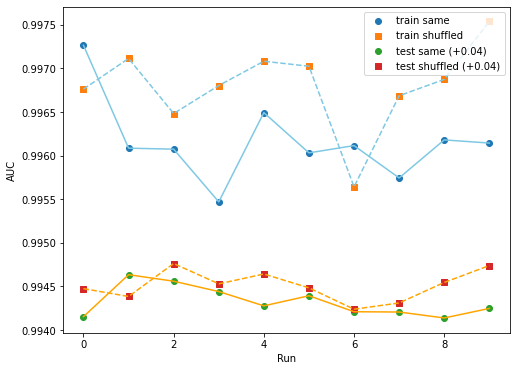

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.plot(same_train_auc, color='#7EC8E3')
plt.plot(same_test_auc + 0.04, color='orange')
plt.plot(shuffled_train_auc, color='#7EC8E3', linestyle='dashed')
plt.plot(shuffled_test_auc + 0.04, color='orange', linestyle='dashed')

plt.scatter(range(NUM_RUNS), same_train_auc, label='train same')
plt.scatter(range(NUM_RUNS), shuffled_train_auc, marker='s', label='train shuffled')
plt.scatter(range(NUM_RUNS), same_test_auc + 0.04, label='test same (+0.04)')
plt.scatter(range(NUM_RUNS), shuffled_test_auc + 0.04, marker='s', label='test shuffled (+0.04)')

plt.legend()
plt.xlabel('Run')
plt.ylabel('AUC');

In [39]:
print("Generalization Gap (Train AUC - Test AUC):")
print(f"(Shuffled) {(shuffled_train_auc - shuffled_test_auc).mean(): .6f} ±{(shuffled_train_auc - shuffled_test_auc).std(): .6f}")
print(f"(Same)     {(same_train_auc - same_test_auc).mean(): .6f} ±{(same_train_auc - same_test_auc).std(): .6f}")

Generalization Gap (Train AUC - Test AUC):
(Shuffled)  0.042289 ± 0.000407
(Same)      0.041833 ± 0.000534


In [40]:
print(f"(Same Test - Shuffled Test): {(same_test_auc - shuffled_test_auc).mean(): .6f} ±{(same_test_auc - shuffled_test_auc).std(): .6f}")

(Same Test - Shuffled Test): -0.000185 ± 0.000208


Shuffled tends to overfit a bit more, but also tends to outpeform same folds. The rate at which shuffled overfits (in the sense of train-test AUC score gap) relative to same folds is one order of magnitude larger than the rate by which it outperforms same folds. Finally, if we look at CV scores at the fold level, there does not seem to be significant differences between the two schemes. 

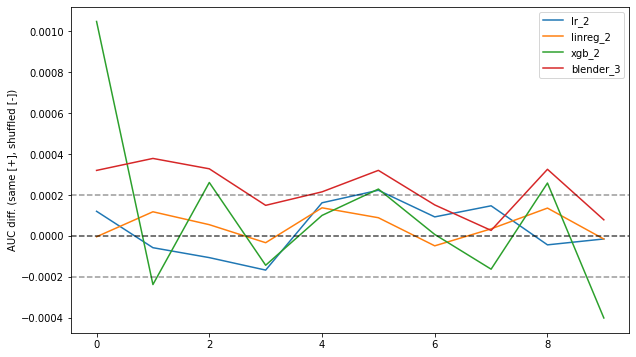

In [41]:
same_minus_shuffled_cv = same_cv_results - shuffled_cv_results
diff = [pd.DataFrame(same_minus_shuffled_cv.iloc[0: NUM_FOLDS, 3:].mean()).T]
for i in range(1, NUM_RUNS):
    diff.append(
        pd.DataFrame(same_minus_shuffled_cv.iloc[NUM_FOLDS*i: NUM_FOLDS*(i+1), 3:].mean()).T
    )
    
pd.concat(diff).plot(use_index=False, figsize=(10, 6), 
                      ylabel='AUC diff. (same [+], shuffled [-])', xlabel='runs'
)
plt.axhline(+0.0002, linestyle='--', color='k', alpha=0.4)
plt.axhline(+0.0000, linestyle='--', color='k', alpha=0.7)
plt.axhline(-0.0002, linestyle='--', color='k', alpha=0.4);

**Figure.** Average over folds of CV score difference for each run of the experiment. Blender model shows a postive score for the same folds method.

:::{note}
Overfitting can happen due to the second level models being highly dependent on a smaller subset of the first level instances when using a different set of folds on the second level. Consider a dataset $\mathbf{X} = \{(\mathbf{x}_1, t_1), (\mathbf{x}_2, t_2) \ldots, (\mathbf{x}_{10}, t_{10})\}$ with five folds such that the first fold is $F_1 = \{\mathbf{x}_1, \mathbf{x}_2\}$. Let $\mathbf{x}_1$ and $\mathbf{x}_2$ be mapped to $\mathbf{y}_1$ and $\mathbf{y}_2$, respectively, such that the mapping is trained on $F_{\neg 1} = \{\mathbf{x}_3, \ldots, \mathbf{x}_{10}\}.$ Modelling on $F_{\neg 1}$ defines some rule or distribution that the points in $F_1$ are compared against. Suppose we reshuffle folds in the next level such that the first fold is $G_1 = \{\mathbf{y}_1, \mathbf{y}_{10}\}.$ Then, the model trained on $G_{\neg 1} = \{\mathbf{y}_2, \ldots \mathbf{y}_9\}$  overfits slightly since $\mathbf{y}_2$ is modelled using the ground truths $(\mathbf{x}_3, t_3), \ldots, (\mathbf{x}_{9}, t_9).$ This imbalance does not apply to other instances $\mathbf{y}_3, \ldots, \mathbf{y}_9$ in $G_{\neg 1}.$ Keeping the same cross-validation folds prevents any such asymmetry from occurring.

Theoretically [^ref3], there is always some leakage when training a second level model on the same training set used to derive the first stage predictions. This is because the ground truth was used to get those first stage predictions, and now these predictions are taken as input to try to predict the same ground truth in the second level. However, this leakage does not seem to be significant in practice.

[^ref3]: As mentioned in the [Kaggle Guide to Model Stacking](https://datasciblog.github.io/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/).
:::

### Conclusion

Empirical and theoretical results above suggest that we should use the **same folds** across levels of stacking if we want to minimize the risk of overfitting. We found that the CV scores of the final model is better when maintaining the same cross-validation folds. However, test scores for shuffled folds are better by a similar margin. 